# Basic basemap plots
This notebook is created on the basis from https://github.com/matplotlib/basemap/blob/master/examples/fillstates.py

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase
import pandas as pd
import numpy as np
from matplotlib.colors import rgb2hex, Normalize
pd.options.display.max_rows = 20

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


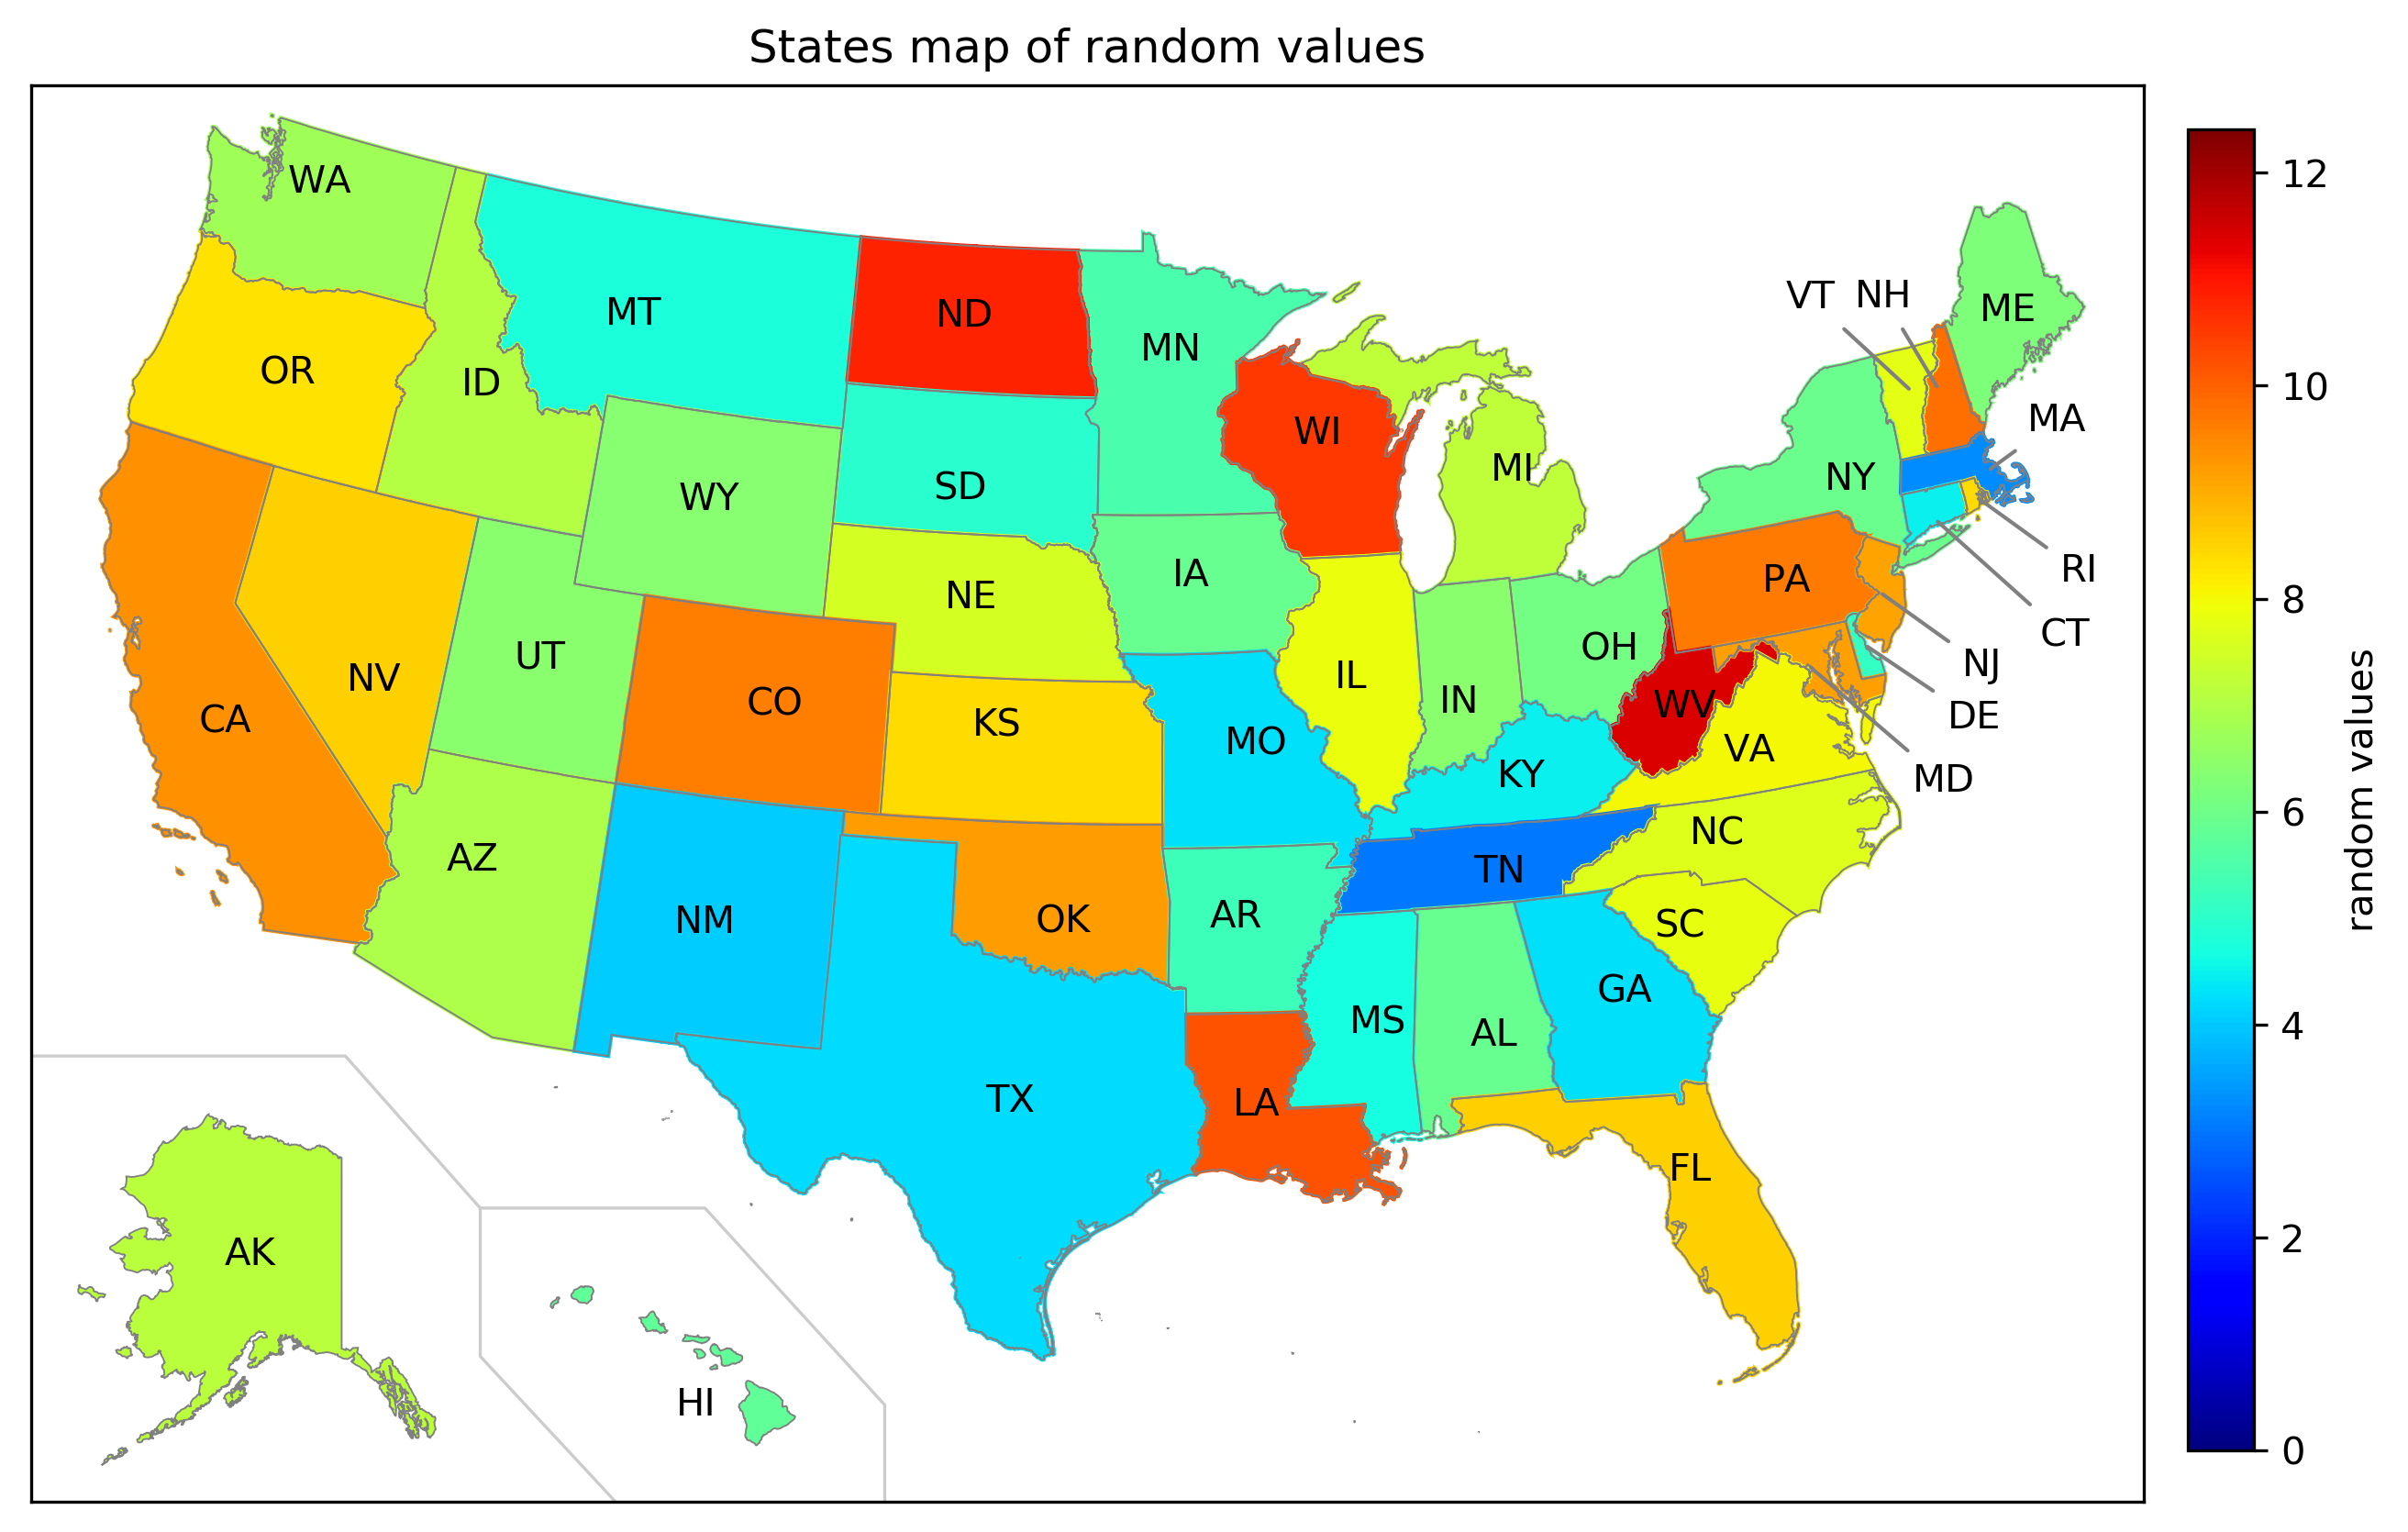

In [2]:
fig = plt.figure(figsize = (8, 6), dpi = 300)
ax = fig.subplots()

# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# Mercator projection, for Alaska and Hawaii
m_ = Basemap(llcrnrlon=-190,llcrnrlat=20,urcrnrlon=-143,urcrnrlat=46,
            projection='merc',lat_ts=20)  # do not change these numbers

# draw state boundaries  
shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')
shp_info_ = m_.readshapefile('st99_d00','states',drawbounds=False)

states = pd.read_csv('states.csv', sep = '\t')
states_dict = states.set_index('State').to_dict()['Abbreviation']

# create some fake data to plot
states['dens'] = states['State'].apply(lambda x: len(x)*np.random.random())
dens_dict = states[['State', 'dens']].set_index('State').to_dict()['dens']

# chose a color for each state
colors = {}
statenames = []
cmap = plt.cm.jet
vmin = 0
vmax = states['dens'].max()*1.05
norm = Normalize(vmin=vmin, vmax=vmax)
for shapedict in m.states_info:
    statename = shapedict['NAME']
    if statename not in ['District of Columbia','Puerto Rico']:
        dens = dens_dict[statename]
        colors[statename] = cmap(np.sqrt((dens-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)

for ind, seg in enumerate(m.states):
    if statenames[ind] not in ['Puerto Rico', 'District of Columbia']:
        color = rgb2hex(colors[statenames[ind]])
        poly = Polygon(seg, facecolor=color, edgecolor=color)
        ax.add_patch(poly)

# some recommended setting
AREA_1 = 0.005  # exclude small Hawaiian islands that are smaller than AREA_1
AREA_2 = AREA_1 * 30.0  # exclude Alaskan islands that are smaller than AREA_2
AK_SCALE = 0.19  # scale down Alaska to show as a map inset
HI_OFFSET_X = -1900000  # X coordinate offset amount to move Hawaii "beneath" Texas
HI_OFFSET_Y = 250000    # similar to above: Y offset for Hawaii
AK_OFFSET_X = -250000   # X offset for Alaska (These four values are obtained
AK_OFFSET_Y = -750000   # via manual trial and error, thus changing them is not recommended.)

# plot Alaska and Hawaii as map insets
for nshape, shapedict in enumerate(m_.states_info):  
    if shapedict['NAME'] in ['Alaska', 'Hawaii']:
        seg = m_.states[int(shapedict['SHAPENUM'] - 1)]
        if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > AREA_1:
            seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
            color = rgb2hex(colors[statenames[nshape]])
        elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > AREA_2:
            seg = [(x*AK_SCALE + AK_OFFSET_X, y*AK_SCALE + AK_OFFSET_Y)\
                   for x, y in seg]
            color = rgb2hex(colors[statenames[nshape]])
        poly = Polygon(seg, facecolor=color, edgecolor='gray', linewidth=.45)
        ax.add_patch(poly)

ax.set_title('States map of random values')


printed_names = set()
wi_index = 0
mi_index = 0
for shapedict, state in zip(m.states_info, m.states):
    state_name = shapedict['NAME']
    if state_name in ['District of Columbia', 'Puerto Rico'] or state_name in printed_names:
        continue
    # center of polygon
    # You have to align x,y manually to avoid overlapping for little states
    shortname = states_dict[state_name]
    if shortname == 'MI' and mi_index != 3:
        mi_index += 1
        continue
    if shortname == 'WI' and wi_index != 2:
        wi_index += 1
        continue
    x, y = np.array(state).mean(axis=0)
    if shortname == 'HI':
        plt.text(1500000, 200000, shortname)
    elif shortname == 'AK':
        plt.text(450000, 550000, shortname)
    elif shortname in {'ND','SD','NE','KS'}:
        plt.text(x-200000, y, shortname, ha="center")
    elif shortname in {'LA', 'AR'}:
        plt.text(x-100000, y, shortname, ha="center")
    elif shortname in {'AZ','WA','MT','FL', 'MS'}:
        plt.text(x+100000, y, shortname, ha="center")
    elif shortname in {'OR','ID'}:
        plt.text(x, y-100000, shortname, ha="center")
    elif shortname in {'KY','TN', 'WV'}:
        plt.text(x, y-50000, shortname, ha="center")
    elif shortname == 'VA':
        plt.text(x+50000, y-50000, shortname, ha="center")
    elif shortname == 'PA':
        plt.text(x-50000, y-50000, shortname, ha="center")
    elif shortname in {'MD', 'CT'}:
        plt.annotate(shortname, xy = (x, y), xytext = (x+250000, y-300000), 
                     arrowprops = {'arrowstyle': '-', 'color': 'gray'})
    elif shortname in {'DE', 'NJ', 'RI'}:
        plt.annotate(shortname, xy = (x, y), xytext = (x+200000, y-200000), 
                     arrowprops = {'arrowstyle': '-', 'color': 'gray'})
    elif shortname == 'MA':
        plt.annotate(shortname, xy = (x, y), xytext = (x+100000, y+100000), 
                     arrowprops = {'arrowstyle': '-', 'color': 'gray'})
    elif shortname == 'VT':
        plt.annotate(shortname, xy = (x, y), xytext = (x-300000, y+200000), 
                     arrowprops = {'arrowstyle': '-', 'color': 'gray'})
    elif shortname == 'NH':
        plt.annotate(shortname, xy = (x, y), xytext = (x-200000, y+200000), 
                     arrowprops = {'arrowstyle': '-', 'color': 'gray'})
    else:
        plt.text(x, y, shortname, ha="center")
    printed_names.add(state_name)
    

#%% ---------  Plot bounding boxes for Alaska and Hawaii insets  --------------
light_gray = [0.8]*3  # define light gray color RGB
x1,y1 = m_([-190,-183,-180,-180,-175,-171,-171],[29,29,26,26,26,22,20])
x2,y2 = m_([-180,-180,-177],[26,23,20])  # these numbers are fine-tuned manually
m_.plot(x1,y1,color=light_gray,linewidth=0.8)  # do not change them drastically
m_.plot(x2,y2,color=light_gray,linewidth=0.8)

#%% ---------   Show color bar  ---------------------------------------
ax_c = fig.add_axes([1, 0.1, 0.03, 0.8])
cb = ColorbarBase(ax_c,cmap=cmap,norm=norm,orientation='vertical',
                  label='random values')
plt.tight_layout()
plt.show()